# This workbook explores distribution of units by content age

<p> The notebook loads data for X number of random customers and explores the distribution of units by content age depending on whether a customer is engaged or not. Engaged means that a customer bought first and last purchase not on the same day and the last purchase occured within last 3 months. Distirbution of first dates show that it is really random, so no skew towards most recent first purchasers. </p>
<p> Query for gettin raw data https://datanet.amazon.com/dw-platform/servlet/dwp/template/EtlViewExtractJobs.vm/job_profile_id/6316440 </p>

<p> The data show that the biggest differences in shares between engaged and not engaged are in deep catalogue (>3yr) and new release (0-30days). What does it mean: all units consumed by engaged are 100%, I make distribution of those units by content age and compare it to the one owned by non_engaged. It implies that engaged are consuming more new releases and deep catalogue </p>

<p> However, if you look at indx of purchases, ie make distribution for first, second, third, after third purchase the picture is slightly different </p>

<br>
<p> Let s look at engaged: at first purchase their share of new and recent release is much bigger than non engaged, it means, that on average engaged customers consume new releases as first entry point, as first purchase. Hypothesis might be those customers are video lovers who can be guided since they rely on new releases as first entry point </p>

<p> Startin with the second purchase, behaviour of engaged on average differs and share of deep catalogue radically increases compared to non engaged suggesting that they have some taste and know what they are looking for. As you might see, the difference only widens as the number of transactions rises </p>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [77]:
#df = pd.read_csv("../EngagementByAgeandType/data/random_age_content.txt", sep= "\t",
#                names = ['transaction_date','customer_id','units','rank','content','age','marketplace','revenue'])

df = pd.read_csv("Z://00_ETL/return_rates/return_rates_content_age_3.txt", sep= "\t", encoding="ISO-8859-1")
#df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [7]:
print(df.shape, df['encrypted_customer_id'].nunique())
df.head()

(12476844, 9) 1181071


,transaction_date_local,encrypted_customer_id,units,rank,content_type_named,content_age,marketplace_id,title_name,revenue
0,2014-02-28,A05353501CHY3WMQ180G4,1,1,Movie VOD,New Release,3.0,Pacific Rim,2.08
1,2014-03-06,A05353501CHY3WMQ180G4,1,2,Movie VOD,New Release,3.0,Elysium,2.91
2,2014-03-16,A05353501CHY3WMQ180G4,1,3,Movie VOD,New Release,3.0,Percy Jackson: Sea Of Monsters,2.91
3,2014-03-17,A05353501CHY3WMQ180G4,1,4,Movie VOD,New Release,3.0,The Hunger Games: Catching Fire,2.91
4,2014-03-31,A05353501CHY3WMQ180G4,1,5,TV Episode,New Release,3.0,Crescent City,1.58


In [8]:
df['transaction_date_local'] = pd.to_datetime(df['transaction_date_local'])

In [9]:
def min_max_dates_by_customer_and_is_engaged(df):
    t = pd.DataFrame(df.groupby("encrypted_customer_id").agg({"transaction_date_local":[np.min,np.max]}).reset_index())
    t.columns = t.columns.droplevel()
    t.columns = ['encrypted_customer_id','first_date','last_date']
    
    m = pd.merge(left=df,right=t,left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = "left")
    
    m['is_engaged'] = np.where((m['last_date'] > m['first_date']) &
    ((m['transaction_date_local'].max() - m['last_date']) / np.timedelta64(1,"M") <= 3),1,0)
    
    return m

In [10]:
t = min_max_dates_by_customer_and_is_engaged(df)

In [11]:
t.head()

,transaction_date_local,encrypted_customer_id,units,rank,content_type_named,content_age,marketplace_id,title_name,revenue,first_date,last_date,is_engaged
0,2014-02-28,A05353501CHY3WMQ180G4,1,1,Movie VOD,New Release,3.0,Pacific Rim,2.08,2014-02-28,2015-08-07,0
1,2014-03-06,A05353501CHY3WMQ180G4,1,2,Movie VOD,New Release,3.0,Elysium,2.91,2014-02-28,2015-08-07,0
2,2014-03-16,A05353501CHY3WMQ180G4,1,3,Movie VOD,New Release,3.0,Percy Jackson: Sea Of Monsters,2.91,2014-02-28,2015-08-07,0
3,2014-03-17,A05353501CHY3WMQ180G4,1,4,Movie VOD,New Release,3.0,The Hunger Games: Catching Fire,2.91,2014-02-28,2015-08-07,0
4,2014-03-31,A05353501CHY3WMQ180G4,1,5,TV Episode,New Release,3.0,Crescent City,1.58,2014-02-28,2015-08-07,0


# Classify customers into engaged and not engaged

In [12]:
print(t['encrypted_customer_id'].nunique())
t.groupby("is_engaged")['encrypted_customer_id'].nunique()

1181071


is_engaged
0    851805
1    329266
Name: encrypted_customer_id, dtype: int64

# Check distribution of first date to not have bias 
<p> Issue were if you include all recent purchasers in to engaged </p>

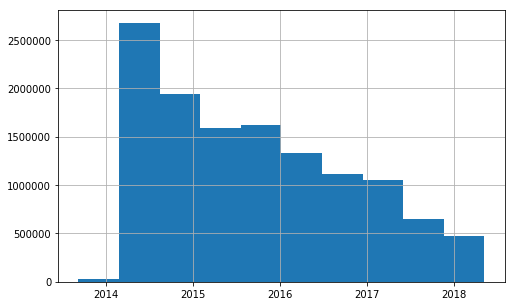

In [13]:
t['first_date'].hist(figsize=(8,5))

# Check difference of age by is_engaged

In [14]:
def get_units_by_age_ranked(df, rank):
    df = df[df['rank'] == rank]
    tr = pd.DataFrame(df.groupby(['is_engaged','content_age','content_type_named'])['units'].sum().reset_index())
    total_units = pd.DataFrame(tr.groupby("is_engaged")['units'].sum().reset_index())
    
    to = pd.merge(left=tr,right=total_units, left_on="is_engaged",right_on="is_engaged",how='left')
    to['share'] = to['units_x'] / to['units_y']
    
    total = pd.DataFrame(to.groupby(["is_engaged","content_age"])['share'].sum().reset_index())
    total['rank'] = rank
    return total

In [15]:
def get_units_by_age(df):
    
    tr = pd.DataFrame(df.groupby(['is_engaged','content_age','content_type_named'])['units'].sum().reset_index())
    total_units = pd.DataFrame(tr.groupby("is_engaged")['units'].sum().reset_index())
    
    to = pd.merge(left=tr,right=total_units, left_on="is_engaged",right_on="is_engaged",how='left')
    to['share'] = to['units_x'] / to['units_y']
    
    total = pd.DataFrame(to.groupby(["is_engaged","content_age"])['share'].sum().reset_index())
    
    return total

In [16]:
def get_units_by_age_and_content(df):
    tr = pd.DataFrame(df.groupby(['is_engaged','content_age','content_type_named'])['units'].sum().reset_index())
    total_units = pd.DataFrame(tr.groupby(["is_engaged",'content_age'])['units'].sum().reset_index())
    
    to = pd.merge(left=tr,right=total_units, left_on=["is_engaged",'content_age'],
                  right_on=["is_engaged",'content_age'],how='left')
    to['share'] = to['units_x'] / to['units_y']
    
    return to

In [17]:
by_age = get_units_by_age(t)
by_age.head()

,is_engaged,content_age,share
0,0,1_2yr_Catalogue,0.179407
1,0,2_3yr_Catalogue,0.126393
2,0,6mo_1yr_Catalogue,0.142096
3,0,Deep Catalogue,0.080142
4,0,New Release,0.182382


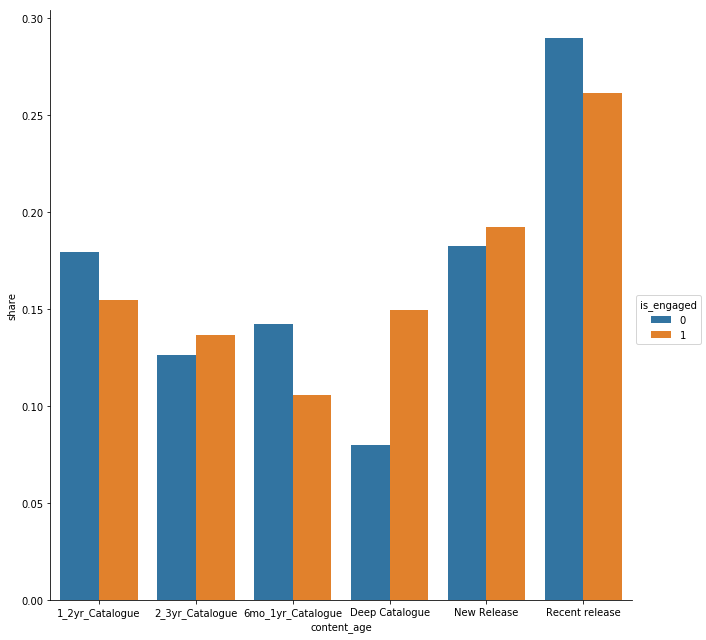

In [18]:
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=by_age, kind='bar', size = 9)

# What is consumed as first purchase

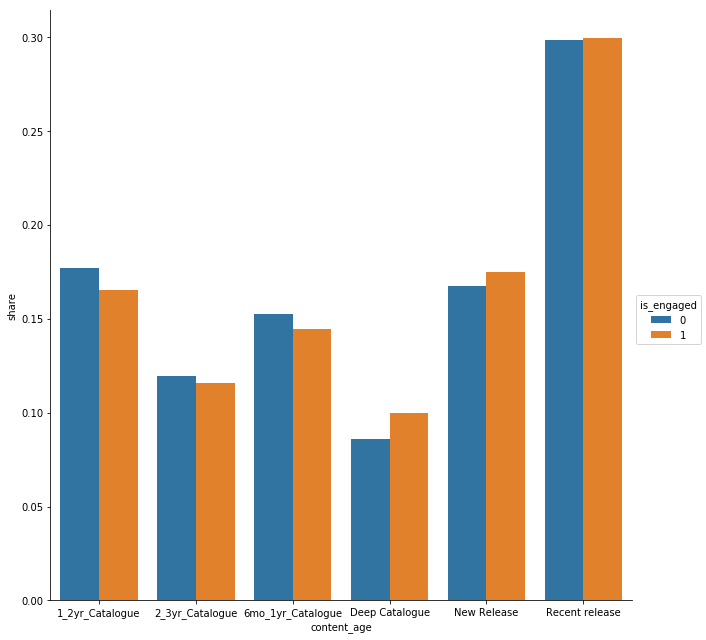

In [19]:
r1 = get_units_by_age_ranked(t,1)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=r1, kind='bar', size = 9)

# What is consumed as second purchase

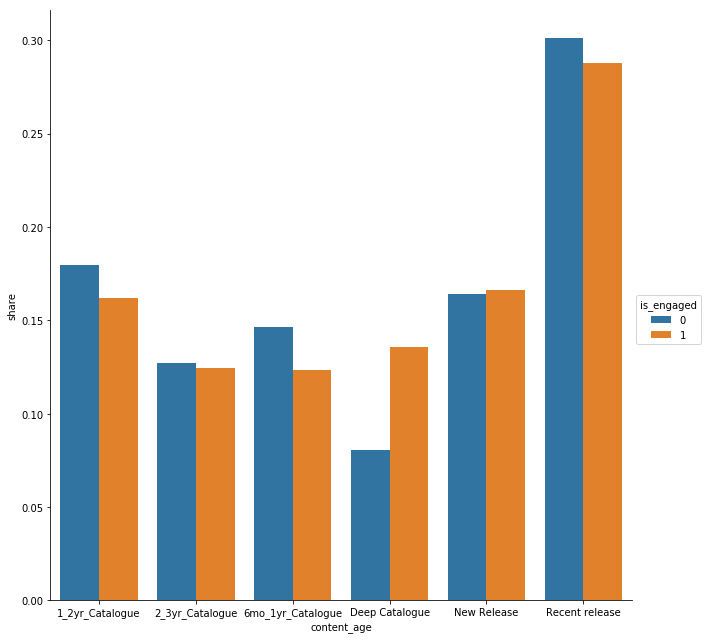

In [21]:
r2 = get_units_by_age_ranked(t,2)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=r2, kind='bar', size = 9)

# What is consumed as third purchase

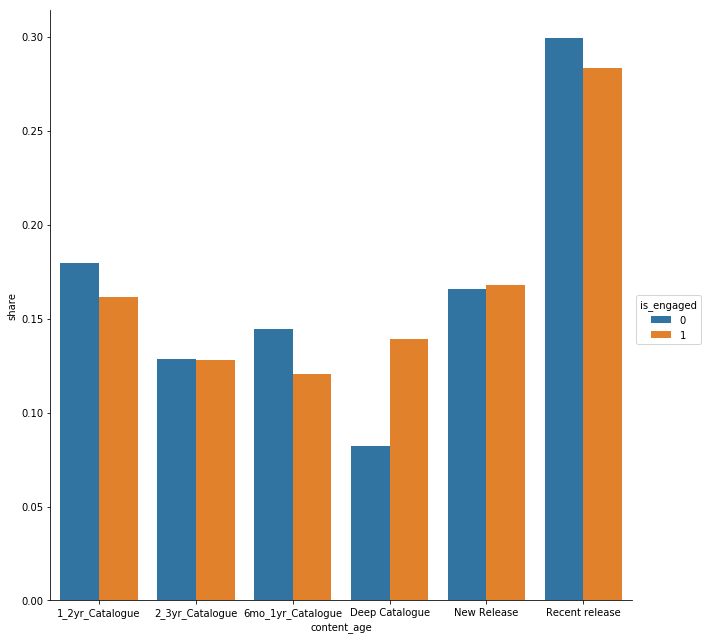

In [22]:
r3 = get_units_by_age_ranked(t,3)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=r3, kind='bar', size = 9)

# What is consumed as fourth purchase

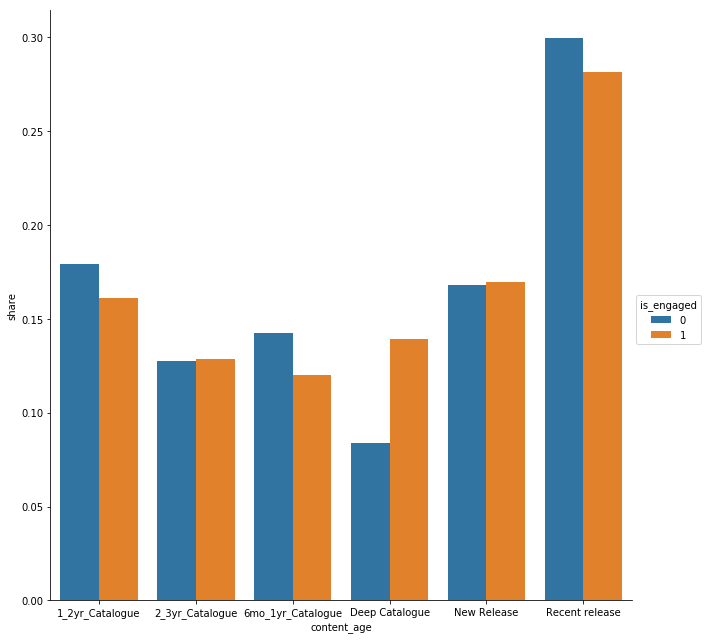

In [23]:
r4 = get_units_by_age_ranked(t,4)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=r4, kind='bar', size = 9)

# What is consumed as fifth purchase

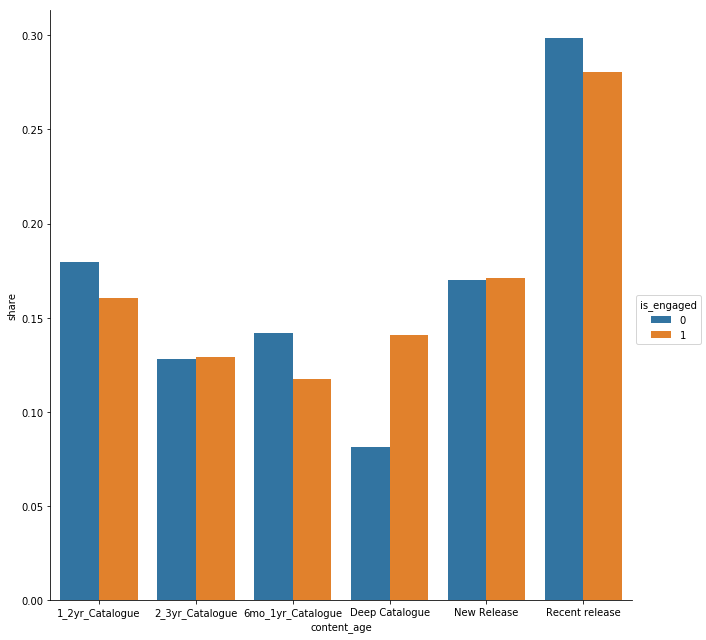

In [24]:
r5 = get_units_by_age_ranked(t,5)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=r5, kind='bar', size = 9)

# What is consumed after third purchase

In [25]:
after5 = t[t['rank'] > 5]

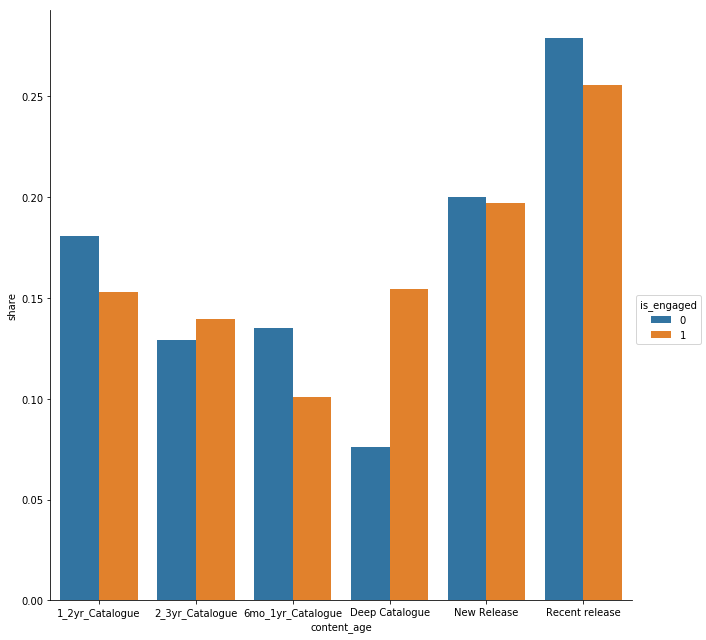

In [26]:
after5_df = get_units_by_age(after5)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=after5_df, kind='bar', size = 9)

In [29]:
list = [r1,r2,r3,r4,r5,after5_df]

In [30]:
#Recall, 'a' append and 'w+' overwrite

# f = open("list_UK_summary.csv", 'w+')
# for i in list:
#     i.to_csv(f)
# f.close()

# Compare one timers vs rest

In [31]:
print(df.shape, t.shape)

(12476844, 9) (12476844, 12)


In [32]:
t.head()

,transaction_date_local,encrypted_customer_id,units,rank,content_type_named,content_age,marketplace_id,title_name,revenue,first_date,last_date,is_engaged
0,2014-02-28,A05353501CHY3WMQ180G4,1,1,Movie VOD,New Release,3.0,Pacific Rim,2.08,2014-02-28,2015-08-07,0
1,2014-03-06,A05353501CHY3WMQ180G4,1,2,Movie VOD,New Release,3.0,Elysium,2.91,2014-02-28,2015-08-07,0
2,2014-03-16,A05353501CHY3WMQ180G4,1,3,Movie VOD,New Release,3.0,Percy Jackson: Sea Of Monsters,2.91,2014-02-28,2015-08-07,0
3,2014-03-17,A05353501CHY3WMQ180G4,1,4,Movie VOD,New Release,3.0,The Hunger Games: Catching Fire,2.91,2014-02-28,2015-08-07,0
4,2014-03-31,A05353501CHY3WMQ180G4,1,5,TV Episode,New Release,3.0,Crescent City,1.58,2014-02-28,2015-08-07,0


In [33]:
def max_rank_per_customer(df):
    max_rank = pd.DataFrame(df.groupby("encrypted_customer_id")['rank'].max().reset_index())
    max_rank.columns = ['encrypted_customer_id', 'max_rank']
    
    m = pd.merge(left=df,right=max_rank,left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = 'left')
    return m

In [34]:
max_rank = max_rank_per_customer(t)

In [35]:
max_rank.head()

,transaction_date_local,encrypted_customer_id,units,rank,content_type_named,content_age,marketplace_id,title_name,revenue,first_date,last_date,is_engaged,max_rank
0,2014-02-28,A05353501CHY3WMQ180G4,1,1,Movie VOD,New Release,3.0,Pacific Rim,2.08,2014-02-28,2015-08-07,0,42
1,2014-03-06,A05353501CHY3WMQ180G4,1,2,Movie VOD,New Release,3.0,Elysium,2.91,2014-02-28,2015-08-07,0,42
2,2014-03-16,A05353501CHY3WMQ180G4,1,3,Movie VOD,New Release,3.0,Percy Jackson: Sea Of Monsters,2.91,2014-02-28,2015-08-07,0,42
3,2014-03-17,A05353501CHY3WMQ180G4,1,4,Movie VOD,New Release,3.0,The Hunger Games: Catching Fire,2.91,2014-02-28,2015-08-07,0,42
4,2014-03-31,A05353501CHY3WMQ180G4,1,5,TV Episode,New Release,3.0,Crescent City,1.58,2014-02-28,2015-08-07,0,42


In [36]:
first_timers = max_rank[max_rank['max_rank'] == 1]
more_than_one_timers = max_rank[max_rank['max_rank'] > 1]

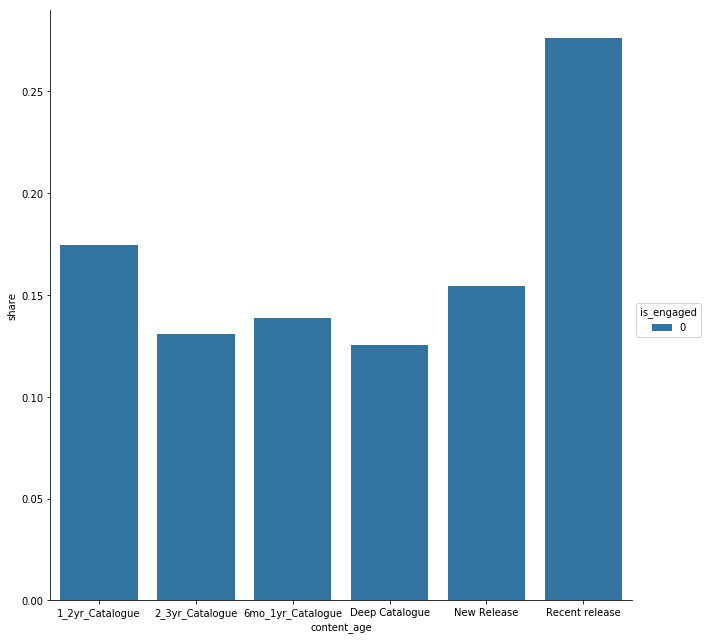

In [37]:
ft = get_units_by_age(first_timers)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=ft, kind='bar', size = 9)

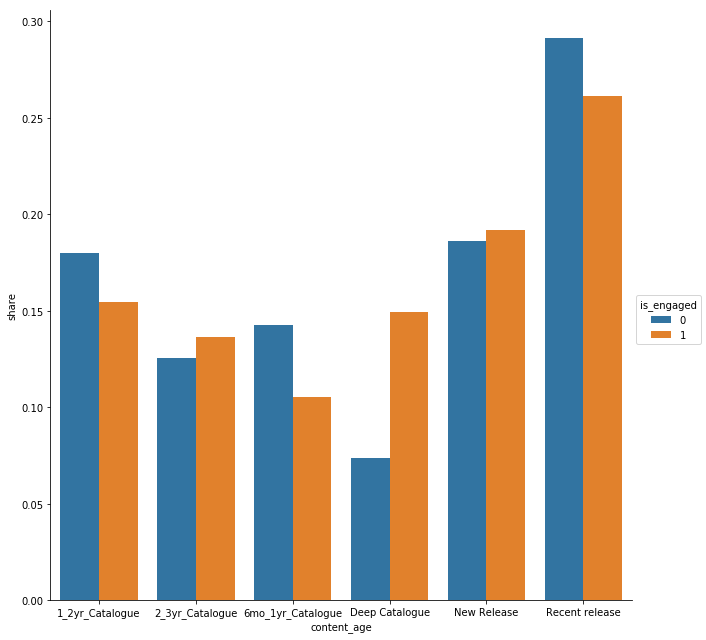

In [39]:
mt = get_units_by_age(more_than_one_timers)
sns.factorplot(x = 'content_age', y = 'share', hue = 'is_engaged', data=mt, kind='bar', size = 9)

In [40]:
ft

,is_engaged,content_age,share
0,0,1_2yr_Catalogue,0.174391
1,0,2_3yr_Catalogue,0.130707
2,0,6mo_1yr_Catalogue,0.138680
3,0,Deep Catalogue,0.125318
4,0,New Release,0.154655
5,0,Recent release,0.276249


In [41]:
mt[mt['content_age'] == 'Deep Catalogue']

,is_engaged,content_age,share
3,0,Deep Catalogue,0.073911
9,1,Deep Catalogue,0.149699


In [42]:
first_timers.head()

,transaction_date_local,encrypted_customer_id,units,rank,content_type_named,content_age,marketplace_id,title_name,revenue,first_date,last_date,is_engaged,max_rank
44,2018-01-18,A0839785395FPCZ7ZHG0,1,1,Movie VOD,2_3yr_Catalogue,3.0,Lord of the Rings: The Return of the King (Ext...,2.91,2018-01-18,2018-01-18,0,1
102,2016-01-09,A104ZB36P1A30K,1,1,TV Episode,6mo_1yr_Catalogue,3.0,Pups Make a Splash / Pups Fall Festival,1.58,2016-01-09,2016-01-09,0,1
103,2016-04-06,A106UFILLH0N6E,1,1,Movie EST,1_2yr_Catalogue,3.0,Eddie Izzard: Force Majeure Live,6.66,2016-04-06,2016-04-06,0,1
152,2017-01-13,A10KEGXJMOBFZU,1,1,Movie VOD,Recent release,3.0,Finding Dory (Theatrical Version),3.71,2017-01-13,2017-01-13,0,1
153,2017-01-13,A10KEGXJMOBFZU,1,1,Movie VOD,Recent release,3.0,Imperium,0.83,2017-01-13,2017-01-13,0,1


# Transform into a set with each row having unique customer 

In [43]:
t['encrypted_customer_id'].nunique()

1181071

In [44]:
def transform_date_set(df):
    u1 = pd.pivot_table(data=df,index="encrypted_customer_id",
                        columns = ['content_age'], values = "units", aggfunc="sum").reset_index()
    u1 = u1.fillna(0)
    u2 = pd.pivot_table(data=df,index="encrypted_customer_id",
                        columns = ['content_type_named'], values = "units", aggfunc="sum").reset_index()
    u2 = u2.fillna(0)
    merged_u = pd.merge(left=u1,right=u2,left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = "left")
    
    merged_u['total_units'] = merged_u['Movie EST'] + merged_u['Movie VOD'] + merged_u['TV Episode'] + merged_u['TV Season'] + merged_u['Unknown']             
    
    #Attach first date,last date and is_engaged
    r = pd.DataFrame(df.groupby('encrypted_customer_id')[['first_date','last_date','is_engaged']].max().reset_index())
    merged_u = pd.merge(left=merged_u,right=r,left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = "left")
    
    #Attach revenue
    revenue = pd.DataFrame(df.groupby("encrypted_customer_id")['revenue'].sum().reset_index())
    merged_u = pd.merge(left=merged_u,right=revenue,left_on="encrypted_customer_id",right_on="encrypted_customer_id", how = "left")
    
        
    return merged_u

In [45]:
merged_u = transform_date_set(t)

In [46]:
merged_u.head()

,encrypted_customer_id,1_2yr_Catalogue,2_3yr_Catalogue,6mo_1yr_Catalogue,Deep Catalogue,New Release,Recent release,Movie EST,Movie VOD,TV Episode,TV Season,Unknown,total_units,first_date,last_date,is_engaged,revenue
0,A000067473PGLTJF0EYD,0.0,2.0,0.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,7.0,2017-07-18,2017-09-09,0,16.62
1,A00010742Y4RNZSX0RGCC,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2017-01-15,2017-08-20,0,23.32
2,A00020501K0ZZ493L8PKI,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2016-02-29,2016-02-29,0,6.66
3,A00036282VGJMPIOTVRQ6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2014-08-23,2014-08-23,0,2.08
4,A00039261XPOLNK4IAXOW,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2017-09-13,2017-09-13,0,2.91


In [47]:
merged_u.shape

(1181071, 17)

In [48]:
def encode_EST_purchasers(df):
    df['is_EST_purchaser'] = np.where(df['total_units'] - df['Movie VOD'] == 0, 0, 1)
    return df

In [49]:
merged_u = encode_EST_purchasers(merged_u)

# Explore the dataset for EST / VOD purchasers

In [50]:
#Check dimensions
print(merged_u['encrypted_customer_id'].nunique(), merged_u.shape)

1181071 (1181071, 18)


In [75]:
merged_u.groupby("is_EST_purchaser").size()

is_EST_purchaser
0    317031
1    864040
dtype: int64

In [53]:
def timing_prep(df):
    df['frequency'] = ((df['last_date'] - df['first_date']) / df['total_units'] )/ np.timedelta64(1,"D")
    df['recency']   = (df['last_date'].max() - df['last_date']) / np.timedelta64(1,"D")
    df['tenure']    = (df['last_date'].max() - df['first_date']) / np.timedelta64(1,"D")
    return df

In [54]:
merged_u = timing_prep(merged_u)

## Make preparations

In [81]:
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score



sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [56]:
merged_u.columns

Index(['encrypted_customer_id', '1_2yr_Catalogue', '2_3yr_Catalogue',
       '6mo_1yr_Catalogue', 'Deep Catalogue', 'New Release', 'Recent release',
       'Movie EST', 'Movie VOD', 'TV Episode', 'TV Season', 'Unknown',
       'total_units', 'first_date', 'last_date', 'is_engaged', 'revenue',
       'is_EST_purchaser', 'frequency', 'recency', 'tenure'],
      dtype='object')

In [278]:
dataset = merged_u[['1_2yr_Catalogue', '2_3yr_Catalogue',
       '6mo_1yr_Catalogue', 'Deep Catalogue', 'New Release', 'Recent release',
       
       'total_units','is_engaged', 'revenue','frequency', 'recency', 'tenure','is_EST_purchaser']]

In [279]:
dataset.shape

(1181071, 13)

In [280]:
dataset.head()

,1_2yr_Catalogue,2_3yr_Catalogue,6mo_1yr_Catalogue,Deep Catalogue,New Release,Recent release,total_units,is_engaged,revenue,frequency,recency,tenure,is_EST_purchaser
0,0.0,2.0,0.0,2.0,1.0,2.0,7.0,0,16.62,7.571429,241.0,294.0,0
1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0,23.32,108.500000,261.0,478.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,6.66,0.000000,799.0,799.0,1
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2.08,0.000000,1354.0,1354.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2.91,0.000000,237.0,237.0,0


In [281]:
X = dataset.iloc[:,0:-1]
Y = dataset.iloc[:,-1]

In [282]:
X.head()

,1_2yr_Catalogue,2_3yr_Catalogue,6mo_1yr_Catalogue,Deep Catalogue,New Release,Recent release,total_units,is_engaged,revenue,frequency,recency,tenure
0,0.0,2.0,0.0,2.0,1.0,2.0,7.0,0,16.62,7.571429,241.0,294.0
1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0,23.32,108.500000,261.0,478.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,6.66,0.000000,799.0,799.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2.08,0.000000,1354.0,1354.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2.91,0.000000,237.0,237.0


In [284]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [285]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(885803, 12) (295268, 12) (885803,) (295268,)


## Logistic regression

In [286]:
#Create instance of the object
logisticRegr = LogisticRegression()

In [287]:
#Train it onto the training set
logisticRegr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [288]:
predictions = logisticRegr.predict(x_test)

In [289]:
print(predictions.shape, y_test.shape)

(295268,) (295268,)


In [290]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[ 50454  28376]
 [ 29399 187039]]


## Make manual calculation of precision, recall, accuracy

<p> Accuracy is (TP + TN) / total </p>
<p> Precision is TP / (TP + FP), ie ability of the classifier not to label as positive a sample that is negative </p>
<p> Recall is TP / (TP + FN), ie the ability of the classifier to find all the positive samples </p>

<p> Macro - Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. </p>

<p> Micro - Calculate metrics globally by counting the total true positives, false negatives and false positives. </p>
<p> Binary, default - Only report results for the class specified by pos_label. This is applicable only if targets  are binary. </p>

In [291]:
accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
print("Accuracy is %s" %accuracy)

precision_total  = cm[0,0] / (cm[0,0]+cm[0,1])
print("Precision is %s" %precision_total)

recall_total  = cm[0,0] / (cm[0,0]+cm[1,0])
print("Recall is %s" %recall_total)

Accuracy is 0.804330303318
Precision is 0.640035519472
Recall is 0.631835998648


In [292]:
print("Accuracy %s" %accuracy_score(y_test, predictions))
print("Precision %s, macro as avg param" %precision_score(y_test,predictions,average="macro"))
print("Precision %s, default" %precision_score(y_test,predictions))
print("Recall %s, macro as avg param" %recall_score(y_test,predictions, average="macro"))
print("Recall %s, default" %recall_score(y_test,predictions))

Accuracy 0.804330303318
Precision 0.750054433648, macro as avg param
Precision 0.868272868649, default
Recall 0.752102236584, macro as avg param
Recall 0.864168953696, default


In [293]:
dataset.is_copy = False
dataset['pred'] = logisticRegr.predict(X)
dataset['probabilities_of_class_1'] = logisticRegr.predict_proba(X)[:,1]

In [311]:
print(dataset.shape)
dataset.head()

(1181071, 16)


,1_2yr_Catalogue,2_3yr_Catalogue,6mo_1yr_Catalogue,Deep Catalogue,New Release,Recent release,total_units,is_engaged,revenue,frequency,recency,tenure,is_EST_purchaser,pred,probabilities_of_class_1,cost
0,0.0,2.0,0.0,2.0,1.0,2.0,7.0,0,16.62,7.571429,241.0,294.0,0,1,0.704037,1
1,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0,23.32,108.500000,261.0,478.0,1,1,0.987274,0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,6.66,0.000000,799.0,799.0,1,1,0.750171,0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2.08,0.000000,1354.0,1354.0,0,0,0.429640,0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,2.91,0.000000,237.0,237.0,0,0,0.356574,0


In [313]:
rm = pd.merge(left=merged_u,right=dataset[['pred','probabilities_of_class_1','cost']], left_index=True, right_index=True, how="left")

In [314]:
rm.head()

,encrypted_customer_id,1_2yr_Catalogue,2_3yr_Catalogue,6mo_1yr_Catalogue,Deep Catalogue,New Release,Recent release,Movie EST,Movie VOD,TV Episode,...,last_date,is_engaged,revenue,is_EST_purchaser,frequency,recency,tenure,pred,probabilities_of_class_1,cost
0,A000067473PGLTJF0EYD,0.0,2.0,0.0,2.0,1.0,2.0,0.0,7.0,0.0,...,2017-09-09,0,16.62,0,7.571429,241.0,294.0,1,0.704037,1
1,A00010742Y4RNZSX0RGCC,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,2017-08-20,0,23.32,1,108.500000,261.0,478.0,1,0.987274,0
2,A00020501K0ZZ493L8PKI,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2016-02-29,0,6.66,1,0.000000,799.0,799.0,1,0.750171,0
3,A00036282VGJMPIOTVRQ6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2014-08-23,0,2.08,0,0.000000,1354.0,1354.0,0,0.429640,0
4,A00039261XPOLNK4IAXOW,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,2017-09-13,0,2.91,0,0.000000,237.0,237.0,0,0.356574,0


In [349]:
rm[rm['encrypted_customer_id'] == 'A000067473PGLTJF0EYD'].iloc[:,np.r_[0,14:len(rm.columns)]]

,encrypted_customer_id,last_date,is_engaged,revenue,is_EST_purchaser,frequency,recency,tenure,pred,probabilities_of_class_1,cost
0,A000067473PGLTJF0EYD,2017-09-09,0,16.62,0,7.571429,241.0,294.0,1,0.704037,1


In [320]:
dataset['cost'] = (dataset['pred'] - dataset['is_EST_purchaser'])**2
dataset['cost'].sum()

231030

In [297]:
dataset[dataset['cost'] != 0].head()

,1_2yr_Catalogue,2_3yr_Catalogue,6mo_1yr_Catalogue,Deep Catalogue,New Release,Recent release,total_units,is_engaged,revenue,frequency,recency,tenure,is_EST_purchaser,pred,probabilities_of_class_1,cost
0,0.0,2.0,0.0,2.0,1.0,2.0,7.0,0,16.62,7.571429,241.0,294.0,0,1,0.704037,1
10,1.0,0.0,3.0,0.0,0.0,0.0,4.0,0,7.07,1.500000,1129.0,1135.0,0,1,0.774609,1
11,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0,6.20,5.333333,506.0,522.0,0,1,0.523894,1
15,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0,10.33,35.666667,391.0,498.0,0,1,0.648195,1
19,0.0,0.0,1.0,1.0,1.0,1.0,4.0,0,11.22,63.250000,240.0,493.0,0,1,0.692044,1
